In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import pandas as pd
import numpy as np

from src.methods.CAA_class import _CAA
from src.methods.OAA_class import _OAA
from src.methods.RBOAA_class import _RBOAA

from src.utils.synthetic_data_class import _synthetic_data
from src.utils.synthetic_data_naive import synthetic_data_naive

from src.utils.eval_measures import NMI, MCC



### Loading in previously generated synthetic data

In [17]:
X_1000 = np.load('SyntheticData/1000_respondents_complex/X.npy') # questionnaire data
A_1000 = np.load('SyntheticData/1000_respondents_complex/A.npy') # weighting of respondents on archetypes
Z_1000 = np.load('SyntheticData/1000_respondents_complex/Z.npy') # archetype matrix (X @ B)

X_50 = np.load('SyntheticData/50_respondents_complex/X.npy')
A_50 = np.load('SyntheticData/50_respondents_complex/A.npy') 
Z_50 = np.load('SyntheticData/50_respondents_complex/Z.npy')

In [20]:
SD = _synthetic_data(M=20, N=1000, K=3, p=5, sigma=-9.21, rb=True, a_param=1.0, b_param=1.5, sigma_std = 1e-6)

print(f'1000 respondents correct? {(SD.X == X_1000).all()}')

SD = _synthetic_data(M=20, N=50, K=3, p=5, sigma=-9.21, rb=True, a_param=1.0, b_param=1.5, sigma_std = 1e-6)

print(f'50 respondents correct? {(SD.X == X_50).all()}')


1000 respondents correct? True
1000 respondents correct? True


In [47]:
print(f'X: {X_1000.shape}')
print(f'A: {A_1000.shape}') # [n_archetypes x n_respondents]
print(f'Z: {Z_1000.shape}')

X: (20, 1000)
A: (3, 1000)
Z: (20, 3)


In [48]:
print(f'Likert scale: {np.unique(X_50)}\n')
print(f'Answer distribution 1000 respondents: {[len(np.where(X_1000==e)[0]) for e in np.unique(X_1000)]}\n')
print(f'Answer distribution 50 respondents: {[len(np.where(X_50==e)[0]) for e in np.unique(X_50)]}')

Likert scale: [1 2 3 4 5]

Answer distribution 1000 respondents: [2076, 5419, 5735, 4082, 2688]

Answer distribution 50 respondents: [108, 278, 276, 187, 151]


### Perform analysis with RBOAA

In [6]:
RBOAA = _RBOAA() # instantiate
rboaa_result = RBOAA._compute_archetypes(X=X_1000,
                          K=3, # how many archetypes to use for analysis
                          p=5, # length of likert scale in X
                          n_iter= 15000, # number of gradient steps
                          lr=0.01,
                          mute=False, # verbosity
                          early_stopping=True, # whether to terminate if loss does not improve
                          with_OAA_initialization=False, # whether to hotstart hyperparameters from OAA analysis
                          beta_regulators=False, # whether to use c1 and c2 as additional hyperparameters to model ordinal scale arbitrarily
                          alternating=False, # whether to first train with a low (and capped) sigma
                          columns=[f'q{i}' for i in range(X_1000.shape[0])]
                          )


Response Bias Ordinal Archetypal Analysis in progress...
Finished Successfully after 3.6 seconds!                               


Analysis ended due to early stopping.

/////////////// INFORMATION ABOUT RESPONSE BIAS ORDINAL ARCHETYPAL ANALYSIS \\\\\\\\\\\\\\\\
▣ The Response Bias Ordinal Archetypal Analysis was computed using 3 archetypes.
▣ The Response Bias Ordinal Archetypal Analysis was computed on 20 attributes.
▣ The Response Bias Ordinal Archetypal Analysis was computed on 1000 subjects.
▣ The Response Bias Ordinal Archetypal Analysis ran for 2401 iterations.
▣ The Response Bias Ordinal Archetypal Analysis took 3.62 seconds to complete.
▣ The final loss was: 2.5443272590637207.


In [7]:
### Extract A and Z matrices from RBOAA result object and compute NMI and MCC
print(f'NMI: {NMI(rboaa_result.A, A_1000)}')
print(f'MCC: {MCC(rboaa_result.Z, Z_1000)}')

NMI: 0.8947018227023921
MCC: 0.9977209694741815


Closing remarks:
* The other methods e.g. OAA and RBOAA also have a _compute_archetypes method which creates a result object.
* The parameters to OAA._compute archetypes are identical to that of RBOAA
* We set up a wrapper class (inside AAM.py). I will make the new changes compatible with that interface before publication - it is not critical for generating results but only helps the user experience.

### OAA analysis

In [8]:
OAA = _OAA() # instantiate
oaa_result = OAA._compute_archetypes(X=X_1000,
                          K=3, # how many archetypes to use for analysis
                          p=5, # length of likert scale in X
                          n_iter= 15000, # number of gradient steps
                          lr=0.01,
                          mute=False, # verbosity
                          early_stopping=True, # whether to terminate if loss does not improve
                          with_CAA_initialization=False,
                          beta_regulators=False, # whether to use c1 and c2 as additional hyperparameters to model ordinal scale arbitrarily
                          alternating=False, # whether to first train with a low (and capped) sigma
                          columns=[f'q{i}' for i in range(X_1000.shape[0])]
                          )


Ordinal Archetypal Analysis in progress...
Finished Successfully after 8.3 seconds!                               

Analysis ended due to early stopping.

/////////////// INFORMATION ABOUT ORDINAL ARCHETYPAL ANALYSIS \\\\\\\\\\\\\\\\
▣ The Ordinal Archetypal Analysis was computed using 3 archetypes.
▣ The Ordinal Archetypal Analysis was computed on 20 attributes.
▣ The Ordinal Archetypal Analysis was computed on 1000 subjects.
▣ The Ordinal Archetypal Analysis ran for 4751 iterations.
▣ The Ordinal Archetypal Analysis took 8.28 seconds to complete.
▣ The final loss was: 16265.205078125.


In [9]:
### Extract A and Z matrices from RBOAA result object and compute NMI and MCC
print(f'NMI: {NMI(oaa_result.A, A_1000)}')
print(f'MCC: {MCC(oaa_result.Z, Z_1000)}')

NMI: 0.4672173367276258
MCC: 0.8432390301194777


In [73]:
CAA = _CAA()
caa_result = CAA._compute_archetypes(X=X_1000,
                          K=3, # how many archetypes to use for analysis
                          p=5, # length of likert scale in X
                          n_iter= 15000, # number of gradient steps
                          lr=0.1,
                          mute=False, # verbosity
                          early_stopping=True, # whether to terminate if loss does not improve
                          columns=[f'q{i}' for i in range(X_1000.shape[0])]
                          )


Conventional Arhcetypal Analysis in progress...
Finished Successfully after 0.4 seconds!                               

Analysis ended due to early stopping.

/////////////// INFORMATION ABOUT CONVENTIONAL ARCHETYPAL ANALYSIS \\\\\\\\\\\\\\\\
▣ The Conventional Archetypal Analysis was computed using 3 archetypes.
▣ The Conventional Archetypal Analysis was computed on 20 attributes.
▣ The Conventional Archetypal Analysis was computed on 1000 subjects.
▣ The Conventional Archetypal Analysis ran for 1376 iterations.
▣ The Conventional Archetypal Analysis took 0.42 seconds to complete.
▣ The final RSS was: 6906.076171875.


In [49]:
### Extract A and Z matrices from RBOAA result object and compute NMI and MCC
print(f'NMI: {NMI(caa_result.A, A_1000)}')
print(f'MCC: {MCC(caa_result.Z, Z_1000)}')

NameError: name 'caa_result' is not defined

### Loss as a function of archetypes

In [3]:
import matplotlib.pyplot as plt
import json
### Load result file

with open('results/result_sigma=-9.21_a=1.0_b=2.0_dev=1e-06.json', 'r') as f:
    result = json.load(f)
    df_res_20 = pd.DataFrame(result)


In [21]:

def loss_archetype_plot(results_path: str = 'synthetic_results/1000_complex_results.json'):
    """
    A plot over the final loss obtained as a function of the number of archetypes
    """
    with open(f'{results_path}', 'r') as f:
        result = json.load(f)
        df_res = pd.DataFrame(result)

    
    methods = df_res['method'].unique()
    methods_colors = dict(zip(methods.tolist(), ['r', 'g', 'b', 'y']))
    plt.figure(figsize=(6,4))

    def add_curve(analysis_archetypes, losses, is_min: bool, method: str):
        if is_min:
            plt.scatter(analysis_archetypes, losses, label=f'{method}', c=methods_colors[method])
            plt.plot(analysis_archetypes, losses, c=methods_colors[method])
        else:
            # plt.scatter(analysis_archetypes, losses)
            plt.plot(analysis_archetypes, losses, alpha=0.3, c=methods_colors[method])
    
    for method in methods:
        df_losses = df_res.loc[df_res['method'] == method][['n_archetypes', 'loss']]
        analysis_archetypes = df_losses['n_archetypes'].unique().tolist()
        
        all_losses = [df_losses.loc[df_losses['n_archetypes'] == e]['loss'].values for e in analysis_archetypes]
        analysis_archetypes = list(map(str, analysis_archetypes))
        losses = np.array([[e[-1] for e in loss] for loss in all_losses]) # n_archetypes x n_repeats array with losses at final iter
        
        tmp = losses[losses == np.min(losses, axis=1)[:, None]]
        _, idx = np.unique(losses[losses == np.min(losses, axis=1)[:, None]], return_index=True)
        min_losses = tmp[np.sort(idx)]
        
        add_curve(analysis_archetypes, min_losses, is_min=True, method=method)

        for rep in range(losses.shape[1]):
            add_curve(analysis_archetypes, losses[:, rep], is_min=False, method=method)
        
        plt.xlabel('n.o. archetypes')
        plt.ylabel('loss')
        plt.legend()
        plt.title(f'Final loss as a function of number of archetypes.')
    plt.show()
    # print(losses)

# loss_archetype_plot(df_res_20)

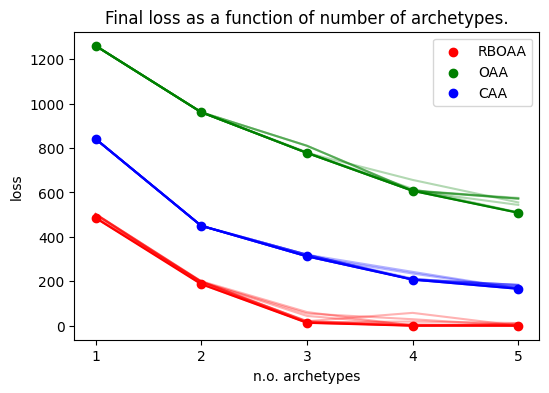

In [24]:
loss_archetype_plot('synthetic_results/50_complex_results.json')

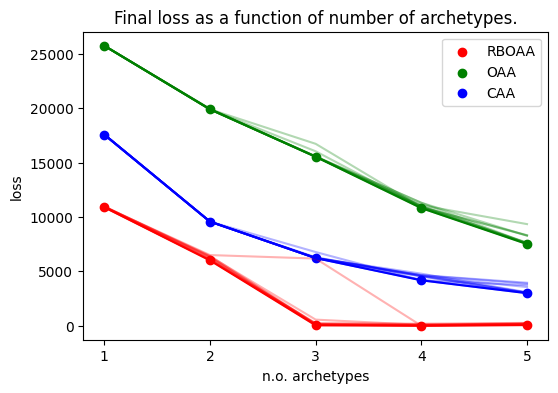

In [27]:
loss_archetype_plot('synthetic_results/1000_complex_results.json')

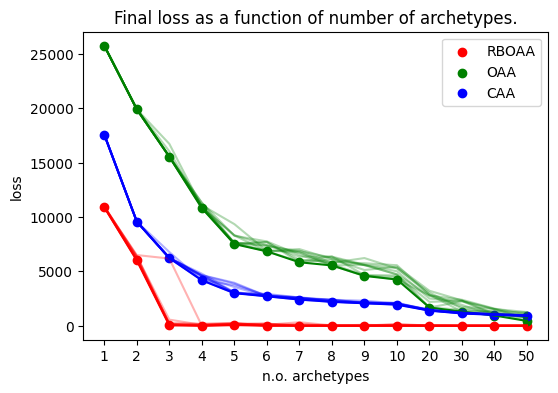

In [28]:
loss_archetype_plot('results/result_sigma=-9.21_a=1.0_b=1.5_dev=1e-06.json')

### Different initialization schemes for A and Z

In [34]:
import torch
def get_matrices(seed: int):
    if seed is not None:
        torch.manual_seed(seed)
    A = torch.log(torch.rand((1000, 3)))
    A /= A.sum(dim=0)

    B = torch.log(torch.rand((3, 1000)))
    B /=  B.sum(dim=0)

    return A, B

def get_CAA_matrices(seed: int):
    A = torch.log(torch.rand((3, 1000)))
    A /= A.sum(dim=1)[:, None]
    B = torch.log(torch.rand((1000, 3)))
    B /=  B.sum(dim=1)[:, None]
    return A, B



In [32]:
import pickle, os

file = open("synthetic_results/complex_corrupted_results/RBOAA_objects/RBOAA_K=3_rep=0",'rb')
object_file = pickle.load(file)
file.close()

In [36]:
os.listdir('synthetic_results/complex_corrupted_results/RBOAA_objects/')[0].split('_')[2][-1]

'0'

In [46]:
D = {'A': {'1'}}

D['B'] = {}
D['B']['C'] = {}


In [42]:
D['A']

TypeError: 'set' object is not subscriptable

In [31]:
def load_result_obj(path: str):
    file = open("synthetic_results/complex_corrupted_results/RBOAA_objects/RBOAA_K=3_rep=0",'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

def load_analyses(analysis_dir: str):
    folder = f'synthetic_results/{analysis_dir}'
    results = {'RBOAA': {}, 'OAA': {}, 'CAA': {}} if 'OSM' not in analysis_dir else {'TSAA': {}}

    for method in results.keys():
        method_dir = f'{folder}/{method}_objects'
        all_files = os.listdir(method_dir)
        for file in all_files:
            obj = load_result_obj(f'{method_dir}/{file}')
            K = int(file.split('_')[1][-1])
            rep = int(file.split('_')[-1][-1])
            if f'K{K}' not in results[method].keys():
                results[method][f'K{K}'] = {}
            
            results[method][f'K{K}'][rep] = obj


NameError: name 'os' is not defined

#### Load TSAA data and perform CAA

In [110]:
import pandas as pd
import itertools
df_TSAA = pd.read_csv('SyntheticData/TSOAA_data_small_naive.csv')

In [111]:
X_TSAA = df_TSAA.values[:, 1:].T # drop the first column because index=True was set when saving to csv
print(f'X_TSAA shape: {X_TSAA.shape}') # TSAA data created by OSM model with ground truth X, A and Z corresponding to synthetic data with 50 respondets.
np.unique(X_TSAA)

X_TSAA shape: (20, 50)


array([1.        , 1.05727611, 1.28462376, 3.09076042, 5.        ])

In [112]:
caa_result = CAA._compute_archetypes(X=X_TSAA,
                          K=3, # how many archetypes to use for analysis
                          p=5, # length of likert scale in X
                          n_iter= 15000, # number of gradient steps
                          lr=0.01,
                          mute=False, # verbosity
                          early_stopping=True, # whether to terminate if loss does not improve
                          columns=[f'q{i}' for i in range(X_1000.shape[0])]
                          )


Conventional Arhcetypal Analysis in progress...
|--------------------|   0.76% finished // 3.8 seconds remaining

Finished Successfully after 0.9 seconds!                               

Analysis ended due to early stopping.

/////////////// INFORMATION ABOUT CONVENTIONAL ARCHETYPAL ANALYSIS \\\\\\\\\\\\\\\\
▣ The Conventional Archetypal Analysis was computed using 3 archetypes.
▣ The Conventional Archetypal Analysis was computed on 20 attributes.
▣ The Conventional Archetypal Analysis was computed on 50 subjects.
▣ The Conventional Archetypal Analysis ran for 6226 iterations.
▣ The Conventional Archetypal Analysis took 0.89 seconds to complete.
▣ The final RSS was: 413.6988525390625.


In [115]:
np.unique(caa_result.Z @ caa_result.A)

array([1.0086275, 1.0099308, 1.0111675, 1.0111957, 1.0116212, 1.011971 ,
       1.0127002, 1.01282  , 1.0128932, 1.0134854, 1.015333 , 1.0155454,
       1.016284 , 1.0164996, 1.0166595, 1.0169455, 1.0171572, 1.0178348,
       1.0182   , 1.0183674, 1.0194882, 1.0198972, 1.0198989, 1.0204632,
       1.0207211, 1.022672 , 1.022896 , 1.0231037, 1.0231506, 1.0233153,
       1.0234793, 1.0236679, 1.0241567, 1.0241876, 1.0244188, 1.0246242,
       1.0255309, 1.0270193, 1.0271894, 1.0275028, 1.0281745, 1.0281864,
       1.0282332, 1.0288692, 1.0289075, 1.0290285, 1.0293797, 1.0295397,
       1.0303262, 1.0304571, 1.0304878, 1.0318835, 1.0336057, 1.0345197,
       1.0376357, 1.0394267, 1.0397379, 1.0433042, 1.0434715, 1.0441272,
       1.0463625, 1.0466982, 1.047583 , 1.0478355, 1.0480999, 1.0515858,
       1.0520054, 1.0520357, 1.0540254, 1.0541123, 1.0546141, 1.0553606,
       1.0556442, 1.0572215, 1.0581862, 1.0582243, 1.0589948, 1.0593874,
       1.0594757, 1.0597365, 1.0610884, 1.0612922, 

In [93]:
print(f'NMI: {NMI(caa_result.A, A_50)}')
print(f'MCC: {MCC(caa_result.Z, Z_50)}')

NMI: 0.03233413306552909
MCC: 0.0018120273139707692


In [94]:
import json
def mean_across_runs(filepath: str = 'results/test_run1.json'):
    with open(filepath, "r") as f:
        res = json.load(f)
        df_res = pd.DataFrame.from_dict(res)
    
    means = df_res.groupby(by=['method', 'with_init', 'alternating', 'beta_reg']).mean()
    print(means)

In [95]:
print("\n\nSynthetic results for 50 respondents:\n")
mean_across_runs('synthetic_results/50_all_combinations.json')



Synthetic results for 50 respondents:

                                            NMI       MCC
method with_init alternating beta_reg                    
CAA    False     False       False     0.330574  0.816241
OAA    False     False       False     0.325728  0.829426
                             True      0.311656  0.829924
                 True        False     0.326393  0.812746
                             True      0.323540  0.823949
       True      False       False     0.319046  0.834171
                             True      0.315653  0.829980
                 True        False     0.314549  0.820270
                             True      0.326788  0.839847
RBOAA  False     False       False     0.719266  0.938891
                             True      0.775822  0.947399
                 True        False     0.713614  0.941022
                             True      0.747149  0.946597
       True      False       False     0.758046  0.946657
                             Tr

In [96]:
print("\n\nSynthetic results for 1000 respondents:\n")
mean_across_runs('synthetic_results/1000_all_combinations.json')



Synthetic results for 1000 respondents:

                                            NMI       MCC
method with_init alternating beta_reg                    
CAA    False     False       False     0.394267  0.789829
OAA    False     False       False     0.461412  0.821073
                             True      0.439974  0.828752
                 True        False     0.414110  0.786289
                             True      0.336443  0.814850
       True      False       False     0.443778  0.816101
                             True      0.441174  0.832549
                 True        False     0.404042  0.796382
                             True      0.415876  0.792723
RBOAA  False     False       False     0.891464  0.997351
                             True      0.888270  0.997210
                 True        False     0.886326  0.997251
                             True      0.884117  0.997977
       True      False       False     0.846529  0.995576
                             

In [36]:
X_1000.shape

(20, 1000)